# Dev Notebook to build the downstream task. 

In [5]:
import sys
import os
sys.path.append("/data1/sascha/LOBCAST_Clean")

os.getcwd()
if os.getcwd() != "/data1/sascha/LOBCAST_Clean":
    print("Changing directory to /data1/sascha/LOBCAST_Clean")
    os.chdir("/data1/sascha/LOBCAST_Clean")


import shutil
shutil.copyfile("/data1/sascha/LOBCAST/src/constants.py","/data1/sascha/LOBCAST_Clean/src/constants_updated.py")

'/data1/sascha/LOBCAST_Clean/src/constants_updated.py'

['lobs5', 'baseline', 'coletta']


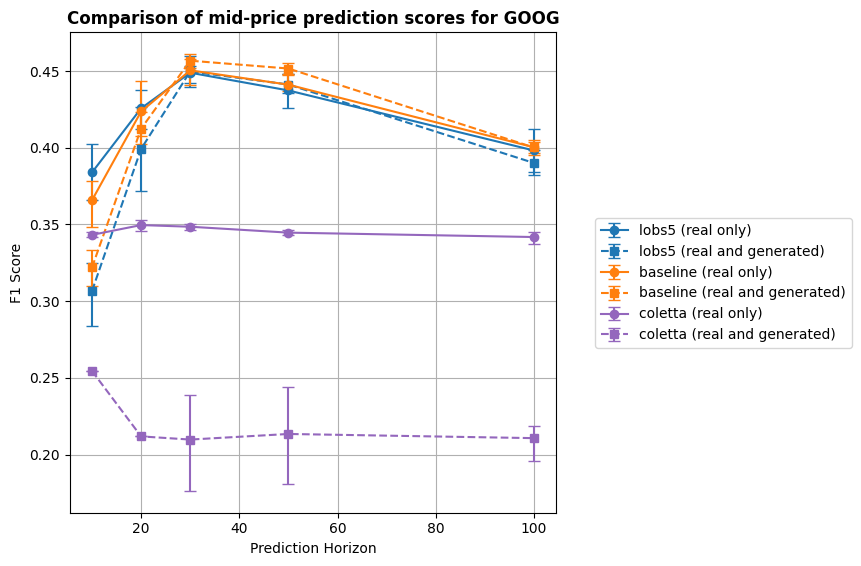

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import bootstrap
import itertools

import matplotlib.pyplot as plt

# Assume you have a DataFrame `results_df` with columns:
# ['stock', 'model', 'case', 'horizon', 'seed', 'f1']

# Example structure:
# results_df = pd.DataFrame({
#     'stock': [...],  # e.g., 'AAPL', 'GOOG'
#     'model': [...],  # e.g., 'LSTM', 'GRU', ...
#     'case': [...],   # e.g., 'real_only', 'real_and_generated'
#     'horizon': [...],# e.g., 1, 2, 3, 4, 5
#     'seed': [...],   # e.g., 0, 1, 2, 3, 4
#     'f1': [...]
# })

# Load the results DataFrame from a CSV file with no headers or indices
# Specify the correct path to your CSV file
csv_path = "../lob_bench/downstream_results.csv"
columns = ['stock', 'model', 'case', 'horizon', 'seed', 'f1']
stocks = ['GOOG']  # Example stock list
results_df = pd.read_csv(csv_path, header=None, names=columns)
models = results_df['model'].unique()


def compute_bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    # data: 1D array-like
    res = bootstrap((np.array(data),), np.mean, confidence_level=ci, n_resamples=n_bootstrap, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

fig, axes = plt.subplots(1, len(stocks), figsize=(6, 6), sharey=True)
if len(stocks) == 1:
    axes = [axes]

horizons = sorted(results_df['horizon'].unique())

# Assign a unique color to each stock for consistency across models/cases
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model: color for model, color in zip(models, itertools.cycle(color_cycle))}
models = [m for m in models if m not in ['rwkv6', 'rwkv4']]
print(models)
case_styles = {
    'real_only': {'linestyle': '-', 'marker': 'o'},
    'real_and_generated': {'linestyle': '--', 'marker': 's'}
}

for i, stock in enumerate(stocks):
    ax = axes[i]
    for model in models:
        color = model_colors[model]
        for case in case_styles.keys():
            means = []
            cis_low = []
            cis_high = []
            for horizon in horizons:
                subset = results_df[
                    (results_df['stock'] == stock) &
                    (results_df['case'] == case) &
                    (results_df['model'] == model) &
                    (results_df['horizon'] == horizon)
                ]['f1'].dropna()
                if len(subset) > 0:
                    mean_f1 = subset.mean()
                    ci_low, ci_high = compute_bootstrap_ci(subset)
                else:
                    mean_f1 = np.nan
                    ci_low, ci_high = np.nan, np.nan
                means.append(mean_f1)
                cis_low.append(ci_low)
                cis_high.append(ci_high)
            label = f"{model} ({case.replace('_', ' ')})"
            style = case_styles.get(case, {})
            ax.errorbar(
                horizons, means,
                yerr=[np.array(means)-np.array(cis_low), np.array(cis_high)-np.array(means)],
                label=label,
                capsize=4,
                color=color,
                **style
            )
    ax.set_title(f"Comparison of mid-price prediction scores for {stock}", fontweight='bold')
    ax.set_xlabel("Prediction Horizon")
    ax.set_ylabel("F1 Score")
    ax.grid(True)

# Create a single legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.rcParams.update({'font.size': 18})

plt.tight_layout()
plt.show()